<a href="https://colab.research.google.com/github/sergiogarciag/hado/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
municipio = '03031'
municipio = '24089'
municipio = '39075'


In [5]:
def cargar_municipio(municipio, provincia):
  with open('/content/drive/My Drive/UNIRTFM/data/pernoctaciones/'+municipio+'.csv', 'r') as f:
    dfPernoctas = pd.read_csv(f, sep='|' , header=0, names=['date','origen', 'destino','y'])
    dfPernoctas['ds'] = pd.to_datetime(dfPernoctas['date'], format='%Y%m%d', errors='coerce')
    dfPernoctas = dfPernoctas.drop('date', axis=1)
    dfPernoctas = dfPernoctas[dfPernoctas['destino'] ==municipio]
    dfPernoctas = dfPernoctas[~dfPernoctas['origen'].astype(str).str.startswith(municipio[0:2])]
    dfPernoctas_grouped = dfPernoctas.groupby(['ds','destino'])['y'].sum().reset_index()
    dfPernoctas_grouped.head()
    dfPernoctas_grouped['mes'] = dfPernoctas_grouped['ds'].dt.month
    dfPernoctas_grouped['anio'] = dfPernoctas_grouped['ds'].dt.year
    dfPernoctas_grouped['diasemana'] = dfPernoctas_grouped['ds'].dt.dayofweek
    dfPernoctas_grouped['findesemana'] = np.logical_or(dfPernoctas_grouped['ds'].dt.dayofweek == 5, dfPernoctas_grouped['ds'].dt.dayofweek == 6).astype(int)
    #dfPernoctas_grouped.set_index('ds', inplace=True)
    dfPernoctas_grouped = dfPernoctas_grouped.drop('destino', axis=1)
    return dfPernoctas_grouped



In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_pernoctas(dfpernoctas, municipio):
  fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
  df_sorted = dfpernoctas.sort_values( by='ds', ascending=True)
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = df_sorted['ds']
  ys = df_sorted['y']
  plt.plot(xs, ys,label='Pernoctaciones '+ municipio, color="steelblue")
  sns.despine(fig=fig, ax=ax)
  plt.xlabel('Fecha')
  _ = plt.ylabel('Pernoctaciones')

In [7]:
dfpernoctasMitma = cargar_municipio(municipio, '')


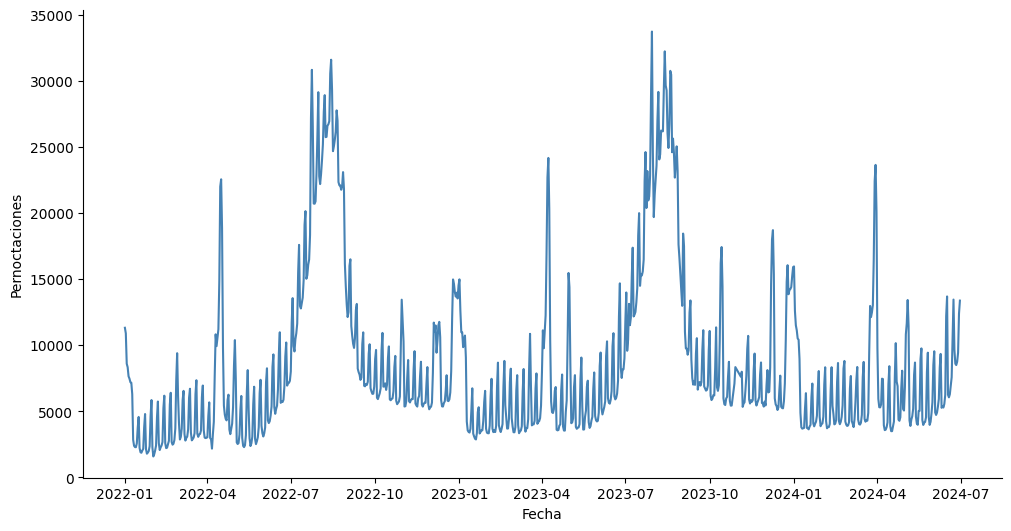

In [8]:
plot_pernoctas(dfpernoctasMitma, municipio)

In [9]:
dfPernoctasResample = dfpernoctasMitma.copy(True)
dfPernoctasResample.set_index('ds', inplace=True)
dfPernoctasMitmaMes = dfPernoctasResample['y'].resample('ME').sum()
def reemplazar_dia(fecha, nuevo_dia):
    return fecha.replace(day=nuevo_dia)
dfPernoctasMitmaMes.index = dfPernoctasMitmaMes.index.map(lambda x: reemplazar_dia(x, 1))
dfPernoctasMitmaMes.head()

,y
ds,
2022-01-01,137420.640
2022-02-01,102946.595
2022-03-01,125889.091
2022-04-01,226643.128
2022-05-01,132496.302


In [10]:
%%script echo no ejecutar
plt.figure(figsize=(12, 6))

#plt.bar(dfmes.index, dfmes['ymitma'], label='mitma', width=10)
#plt.plot(dfmes.index, dfmes['yine'], label='ine')
plt.plot(dfmes.index, dfmes['ymitma']/dfmes['yine'], label='pernoctas', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Total y Pernoctaciones por Fecha')
plt.legend()
plt.grid(True)
plt.show()

no ejecutar


In [11]:
from prophet.make_holidays import make_holidays_df

semanasanta = pd.DataFrame({
  'holiday': 'semanasanta',
  'ds': pd.to_datetime(['2022-04-17', '2023-04-09', '2024-03-31']),
  'lower_window': -9,
  'upper_window': 0,
})
navidad = pd.DataFrame({
  'holiday': 'navidad',
  'ds': pd.to_datetime(['2022-12-25', '2023-12-25', '2024-12-25']),
  'lower_window': -4,
  'upper_window': 12,
})
verano = pd.DataFrame({
  'holiday': 'verano',
  'ds': pd.to_datetime(['2022-07-01', '2023-07-01', '2024-07-01']),
  'lower_window': 0,
  'upper_window': 62,
})
year_list = [2022,2023,2024]
vacaciones_es = make_holidays_df(year_list=year_list,
                            country='ES')
vacaciones = pd.concat((vacaciones_es,semanasanta,navidad,verano))

In [12]:
%%script echo skipping
diasvacaciones = pd.DataFrame(columns=['date', 'vacaciones'])
date_range = pd.date_range(start='2022-01-01', end='2024-12-31')

for date in date_range:
        new_row = pd.DataFrame({'date': [date], 'vacaciones': [0]})
        diasvacaciones = pd.concat([diasvacaciones, new_row], ignore_index=True)

for index, row in vacaciones.iterrows():
  date = row['ds']
  print(row)
  lower_window = row['lower_window']
  upper_window = row['upper_window']
  if np.isnan(lower_window) :
    lower_window = int(0)
  if np.isnan(upper_window) :
    upper_window = int(0)

  for i in range(int(lower_window), int(upper_window) +1):
    new_date = date + pd.DateOffset(days=i)
    print(new_date)
    diasvacaciones.loc[diasvacaciones['date'] == new_date, 'vacaciones'] = 1

diasvacaciones.to_csv('/content/drive/My Drive/UNIRTFM/data/diasvacaciones.csv', index=False)


skipping


In [13]:
%%script echo skipping
diassemanasanta = pd.DataFrame(columns=['date', 'semanasanta'])
date_range = pd.date_range(start='2022-01-01', end='2024-12-31')

for date in date_range:
        new_row = pd.DataFrame({'date': [date], 'semanasanta': [0]})
        diassemanasanta = pd.concat([diassemanasanta, new_row], ignore_index=True)

for index, row in vacaciones.iterrows():
  date = row['ds']
  print(row)
  lower_window = row['lower_window']
  upper_window = row['upper_window']
  if np.isnan(lower_window) :
    lower_window = int(0)
  if np.isnan(upper_window) :
    upper_window = int(0)

  if row['holiday'] == 'semanasanta':
    for i in range(int(lower_window), int(upper_window) +1):
      new_date = date + pd.DateOffset(days=i)
      print(new_date)
      diassemanasanta.loc[diassemanasanta['date'] == new_date, 'semanasanta'] = 1

diassemanasanta.to_csv('/content/drive/My Drive/UNIRTFM/data/semanasanta.csv', index=False)

skipping


In [14]:
from prophet import Prophet
m = Prophet(holidays=vacaciones)
m.fit(dfpernoctasMitma[dfpernoctasMitma['ds'] < '2023-12-31'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnt2qpid/kvq_dfs6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnt2qpid/jw5djpvq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77649', 'data', 'file=/tmp/tmpbnt2qpid/kvq_dfs6.json', 'init=/tmp/tmpbnt2qpid/jw5djpvq.json', 'output', 'file=/tmp/tmpbnt2qpid/prophet_modeluc0o616e/prophet_model-20250103224705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


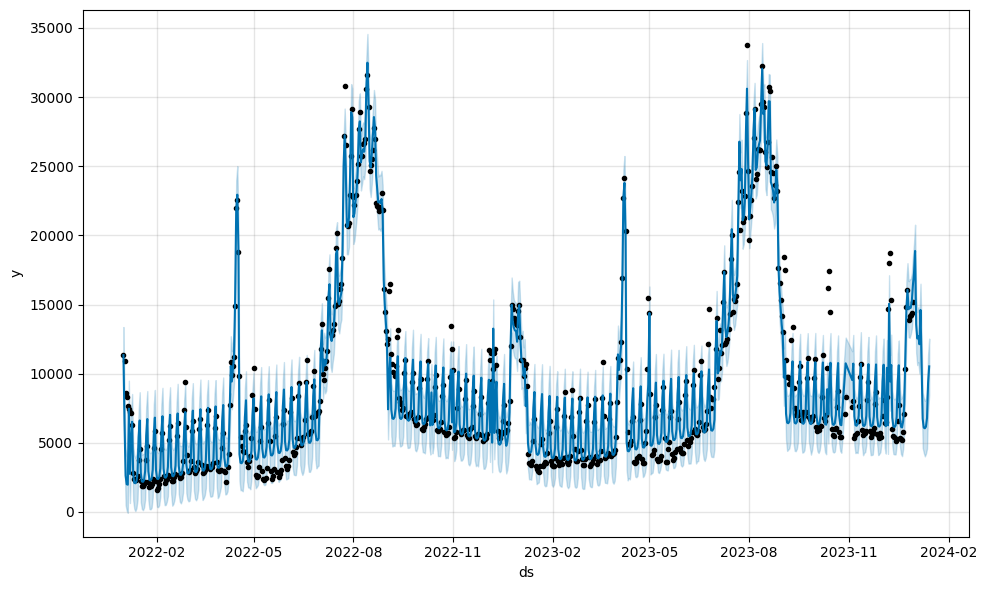

In [15]:
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)


In [16]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [17]:
plot_plotly(m, forecast)


In [18]:
import numpy as np
def cargar_meteo(municipio):
  with open('/content/drive/My Drive/UNIRTFM/data/meteo/'+municipio+'.csv', 'r') as f:
    dfMeteo = pd.read_csv(f, sep=',' , encoding='iso-8859-1')
    dfMeteo['claro'] = (dfMeteo['icon'] == 'clear-day').astype(int)
    dfMeteo['precipitacion'] = np.logical_or(dfMeteo['icon'] == 'rain' , dfMeteo['icon'] == 'snow').astype(int)
    dfMeteo['cubierto'] = np.logical_or(dfMeteo['icon'] == 'partly-cloudy-day' , dfMeteo['icon'] == 'cloudy').astype(int)
    dfMeteo = dfMeteo.drop(['tempmax',	'tempmin','precip','precipprob','precipcover',	'preciptype'	,'cloudcover','icon'], axis=1)
    return dfMeteo


dfmeteo = cargar_meteo(municipio)





In [19]:
dfmeteo.columns

Index(['name', 'datetime', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike',
       'dew', 'humidity', 'snow', 'snowdepth', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'stations', 'claro',
       'precipitacion', 'cubierto'],
      dtype='object')

In [20]:
dfmeteo= dfmeteo.drop(dfmeteo.columns[0],axis=1)
dfmeteo


,datetime,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,snow,snowdepth,windgust,...,severerisk,sunrise,sunset,moonphase,conditions,description,stations,claro,precipitacion,cubierto
0,2022-01-01,20.4,22.8,16.0,20.4,5.6,38.5,0,0.0,42.5,...,NaN,2022-01-01T08:48:16,2022-01-01T17:49:34,0.95,Partially cloudy,Partly cloudy throughout the day.,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,0,1
1,2022-01-02,16.4,21.6,12.9,16.4,9.2,65.7,0,0.0,44.6,...,NaN,2022-01-02T08:48:19,2022-01-02T17:50:27,0.00,Partially cloudy,Partly cloudy throughout the day.,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,0,1
2,2022-01-03,15.1,20.5,8.0,15.0,8.0,65.3,0,0.0,63.0,...,NaN,2022-01-03T08:48:19,2022-01-03T17:51:23,0.02,Partially cloudy,Partly cloudy throughout the day.,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,0,1
3,2022-01-04,13.0,18.7,5.2,11.8,8.5,76.6,0,0.0,61.2,...,NaN,2022-01-04T08:48:17,2022-01-04T17:52:20,0.06,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,"08023099999,08025099999,LEXJ,C4320,C3583,08021...",0,1,0
4,2022-01-05,8.7,10.6,5.4,7.2,4.6,75.7,0,0.0,50.4,...,NaN,2022-01-05T08:48:13,2022-01-05T17:53:19,0.09,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,10.2,12.9,6.3,9.8,9.0,92.5,0,0.0,17.3,...,NaN,2024-12-27T08:47:30,2024-12-27T17:45:46,0.89,"Rain, Partially cloudy",Clearing in the afternoon with afternoon rain.,"08023099999,08025099999,C3583,LEXJ,08021099999...",0,1,0
1092,2024-12-28,9.0,13.0,3.9,8.8,7.1,89.0,0,0.0,16.6,...,NaN,2024-12-28T08:47:44,2024-12-28T17:46:31,0.92,Partially cloudy,Becoming cloudy in the afternoon.,"C3583,LEXJ,LEBB",0,0,1
1093,2024-12-29,9.3,14.0,5.9,9.2,6.9,85.4,0,0.0,13.7,...,NaN,2024-12-29T08:47:56,2024-12-29T17:47:18,0.95,Partially cloudy,Partly cloudy throughout the day.,"C3583,LEXJ,LEBB",0,0,1
1094,2024-12-30,6.4,12.0,1.6,6.3,4.7,89.9,0,0.0,11.2,...,NaN,2024-12-30T08:48:06,2024-12-30T17:48:06,0.00,Clear,Clear conditions throughout the day.,"C3583,LEXJ,LEBB",1,0,0


In [21]:

dfmeteo['ds'] = pd.to_datetime(dfmeteo['datetime'])
dfmeteo.set_index('ds', inplace=True)

df_final = pd.merge(dfpernoctasMitma, dfmeteo, on='ds', how='left')

In [22]:
def crear_modelo(dfPernoctas,vacaciones,regresores):

  modelo = Prophet(holidays=vacaciones)
  for regresor in regresores:
    modelo.add_regressor(regresor)

  modelo.fit(dfPernoctas)

  df_cv = cross_validation(modelo,
                         horizon='7 days',
                         period='7 days',
                         initial='730 days',
                         parallel='processes')

  df_p = performance_metrics(df_cv)
  return df_p

def plot_modelo(dfPernoctas,vacaciones,regresores):

  modelo = Prophet(holidays=vacaciones)
  for regresor in regresores:
    modelo.add_regressor(regresor)

  modelo.fit(dfPernoctas[dfPernoctas['ds'] <= '2023-12-31'])
  future = modelo.make_future_dataframe(periods=174)
  forecast = modelo.predict(future)
  modelo.plot(forecast)





In [23]:
diasemana = dfpernoctasMitma.groupby('diasemana').agg({'y': 'mean'}).reset_index()
diasemana

,diasemana,y
0,0,7899.022837
1,1,7248.029109
2,2,7166.315248
3,3,7530.537386
4,4,8208.598102
5,5,10734.918282
6,6,11808.253786


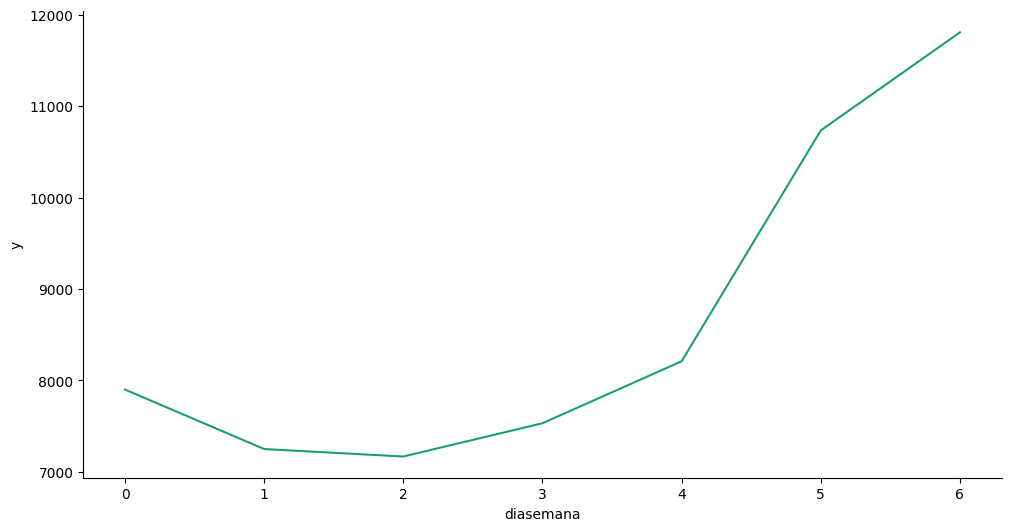

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['diasemana']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = diasemana.sort_values('diasemana', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('diasemana')
_ = plt.ylabel('y')

In [25]:
metricas_todo = crear_modelo(df_final, vacaciones,   ['temp', 'precipitacion','findesemana','claro','cubierto'])
metricas_meteo = crear_modelo(df_final, None,   ['temp', 'precipitacion'])
metricas_findes = crear_modelo(df_final, None,   ['findesemana'])
metricas_vacaciones = crear_modelo(df_final, vacaciones,   [ ])
metricas = crear_modelo(df_final, None,   [ ])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnt2qpid/ouow3qeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnt2qpid/20rqgs3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51532', 'data', 'file=/tmp/tmpbnt2qpid/ouow3qeu.json', 'init=/tmp/tmpbnt2qpid/20rqgs3y.json', 'output', 'file=/tmp/tmpbnt2qpid/prophet_model5z6u8v64/prophet_model-20250103224708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 25 forecasts with cutoffs between 2024-01-07 00:00:00 and 2024-06-23 00:00:00
INFO:prophet:Applying in parallel with <conc

In [26]:
metricas_todo['mape'].mean()


0.1256590871208259

In [27]:
metricas

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,4.532556e+06,2128.980079,1307.646993,0.258005,0.125598,0.217982,0.840000
1,2 days,5.066847e+06,2250.965816,1321.834801,0.275691,0.087120,0.234483,0.800000
2,3 days,5.587376e+06,2363.763166,1377.246682,0.281256,0.059055,0.246010,0.800000
3,4 days,9.001766e+06,3000.294320,1635.356629,0.271564,0.104531,0.256826,0.833333
4,5 days,1.501606e+07,3875.055710,2083.350213,0.313736,0.163895,0.281824,0.760000
5,6 days,1.310175e+07,3619.633598,2055.550020,0.214576,0.100866,0.203966,0.800000
6,7 days,8.208968e+06,2865.129742,1810.367552,0.180609,0.092909,0.168800,0.800000


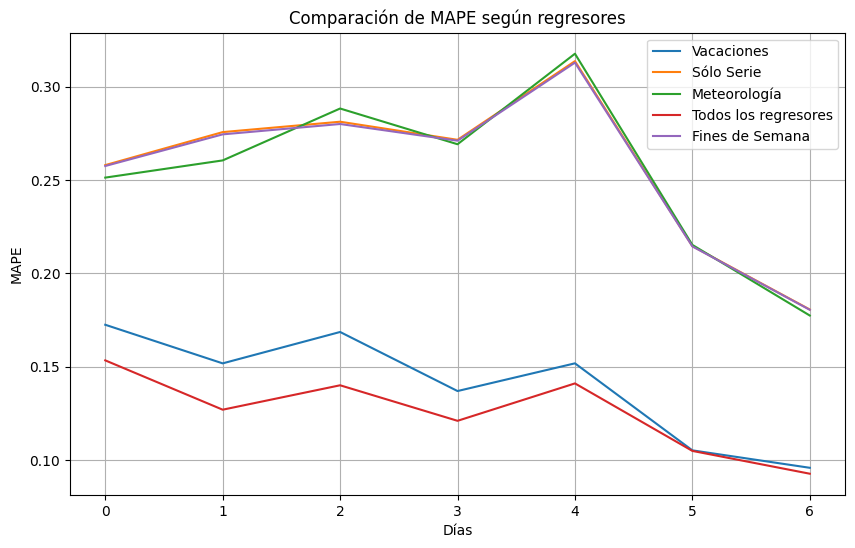

In [28]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(metricas_vacaciones['mape'], label='Vacaciones')
plt.plot(metricas['mape'], label='Sólo Serie')
plt.plot(metricas_meteo['mape'], label='Meteorología')
plt.plot(metricas_todo['mape'], label='Todos los regresores')
plt.plot(metricas_findes['mape'], label='Fines de Semana')

plt.xlabel('Días')
plt.ylabel('MAPE')
plt.title('Comparación de MAPE según regresores')
plt.legend()
filename = '/content/drive/My Drive/UNIRTFM/figuras/mape_regresores_'+municipio+'.png'
plt.savefig(filename)
plt.grid(True)
plt.show()

In [29]:
df_final

,ds,y,mes,anio,diasemana,findesemana,datetime,temp,feelslikemax,feelslikemin,...,severerisk,sunrise,sunset,moonphase,conditions,description,stations,claro,precipitacion,cubierto
0,2022-01-01,11323.846,1,2022,5,1,2022-01-01,20.4,22.8,16.0,...,NaN,2022-01-01T08:48:16,2022-01-01T17:49:34,0.95,Partially cloudy,Partly cloudy throughout the day.,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,0,1
1,2022-01-02,10900.624,1,2022,6,1,2022-01-02,16.4,21.6,12.9,...,NaN,2022-01-02T08:48:19,2022-01-02T17:50:27,0.00,Partially cloudy,Partly cloudy throughout the day.,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,0,1
2,2022-01-03,8604.023,1,2022,0,0,2022-01-03,15.1,20.5,8.0,...,NaN,2022-01-03T08:48:19,2022-01-03T17:51:23,0.02,Partially cloudy,Partly cloudy throughout the day.,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,0,1
3,2022-01-04,8340.414,1,2022,1,0,2022-01-04,13.0,18.7,5.2,...,NaN,2022-01-04T08:48:17,2022-01-04T17:52:20,0.06,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,"08023099999,08025099999,LEXJ,C4320,C3583,08021...",0,1,0
4,2022-01-05,7649.545,1,2022,2,0,2022-01-05,8.7,10.6,5.4,...,NaN,2022-01-05T08:48:13,2022-01-05T17:53:19,0.09,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,"08023099999,08025099999,LEXJ,C3583,08021099999...",0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,2024-06-26,8503.230,6,2024,2,0,2024-06-26,20.3,22.5,18.3,...,NaN,2024-06-26T06:36:13,2024-06-26T22:00:14,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,"08023099999,08025099999,C3583,LEXJ,08021099999...",0,1,0
900,2024-06-27,8754.362,6,2024,3,0,2024-06-27,19.4,21.6,18.5,...,NaN,2024-06-27T06:36:38,2024-06-27T22:00:13,0.69,"Rain, Overcast",Cloudy skies throughout the day with rain.,"08023099999,08025099999,C3583,LEXJ,08021099999...",0,1,0
901,2024-06-28,9438.605,6,2024,4,0,2024-06-28,18.9,20.4,17.3,...,NaN,2024-06-28T06:37:04,2024-06-28T22:00:10,0.75,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,"08023099999,08025099999,C3583,LEXJ,08021099999...",0,1,0
902,2024-06-29,12390.128,6,2024,5,1,2024-06-29,17.0,18.2,15.8,...,NaN,2024-06-29T06:37:32,2024-06-29T22:00:04,0.76,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,"08023099999,08025099999,C3583,LEXJ,C4320,08021...",0,1,0


In [30]:
import os
from datetime import datetime

def guardar_mape(metodo, municipio, mape):
  """Guarda el MAPE en un archivo CSV.

  Args:
    metodo: El método utilizado para calcular el MAPE.
    municipio: El municipio al que corresponde el MAPE.
    mape: El valor del MAPE.
  """
  timestamp_ejecucion = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  file_path = '/content/drive/My Drive/UNIRTFM/resultados/mape.csv'

  if os.path.exists(file_path):
    df = pd.read_csv(file_path)
  else:
    df = pd.DataFrame(columns=['metodo', 'municipio', 'timestamp_ejecucion', 'mape'])

  new_data = pd.DataFrame({'metodo': [metodo],
                            'municipio': [municipio],
                            'timestamp_ejecucion': [timestamp_ejecucion],
                            'mape': [mape]})

  df = pd.concat([df, new_data], ignore_index=True)
  df.to_csv(file_path, index=False)

# Ejemplo de uso (reemplaza con tus valores reales)
guardar_mape("Prophet", municipio, np.mean( metricas_todo['mape']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnt2qpid/fhzftw5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbnt2qpid/pd7ql9hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68046', 'data', 'file=/tmp/tmpbnt2qpid/fhzftw5s.json', 'init=/tmp/tmpbnt2qpid/pd7ql9hi.json', 'output', 'file=/tmp/tmpbnt2qpid/prophet_modelelk8ga2l/prophet_model-20250103224814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


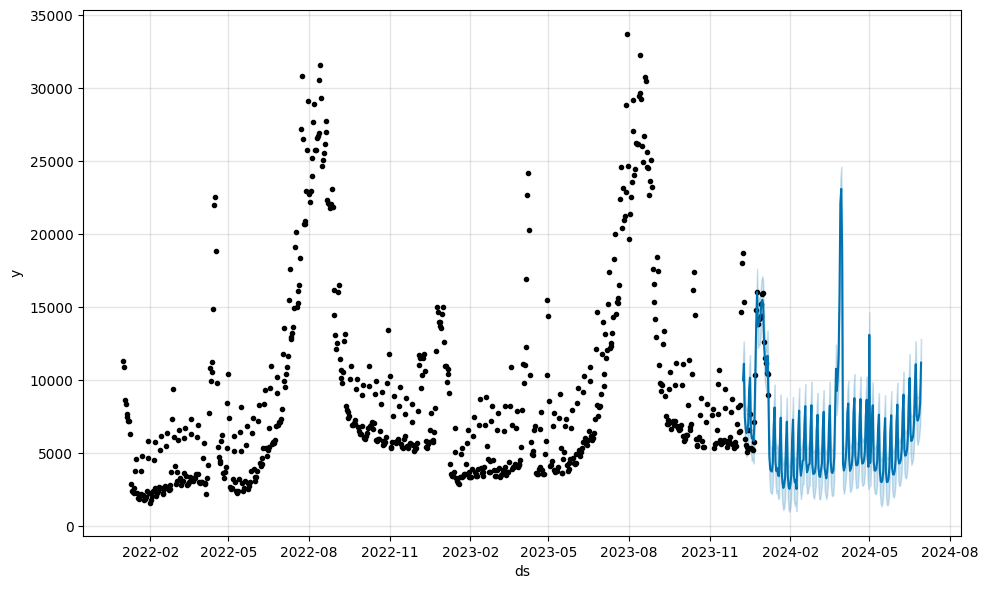

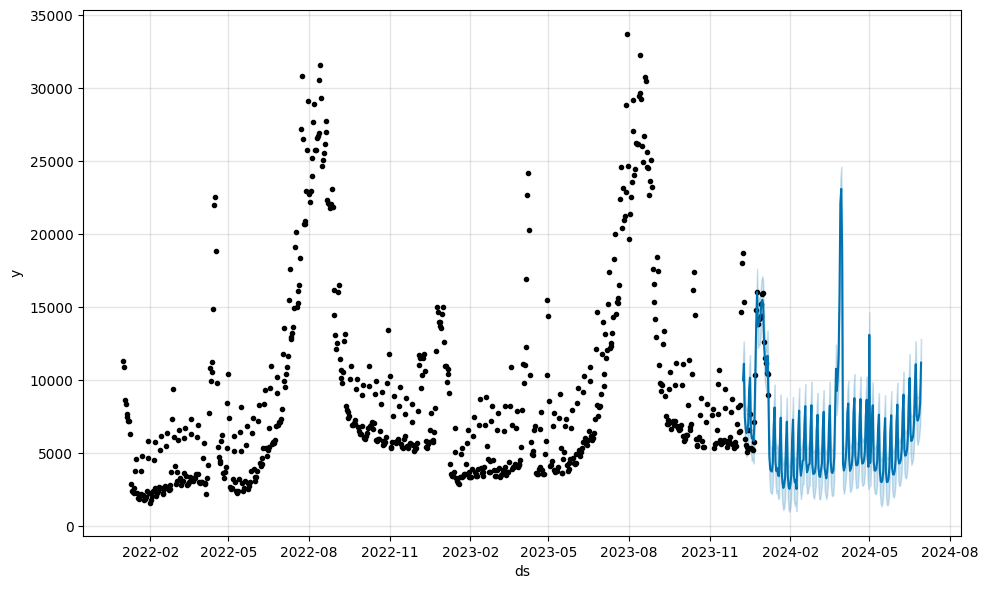

In [31]:

modelo_final = Prophet(holidays=vacaciones)
for regresor in ('temp', 'precipitacion','findesemana','claro','cubierto'):
  modelo_final.add_regressor(regresor)

modelo_final.fit(df_final.iloc[0:730])
futuro = modelo_final.make_future_dataframe(periods=174)
futuro['temp']=df_final['temp'].iloc[:904].values
futuro['precipitacion']=df_final['precipitacion'].iloc[:904].values
futuro['findesemana']=df_final['findesemana'].iloc[:904].values
futuro['claro']=df_final['claro'].iloc[:904].values
futuro['cubierto']=df_final['cubierto'].iloc[:904].values

forecast = modelo_final.predict(futuro)
modelo_final.plot(forecast.iloc[700:],)



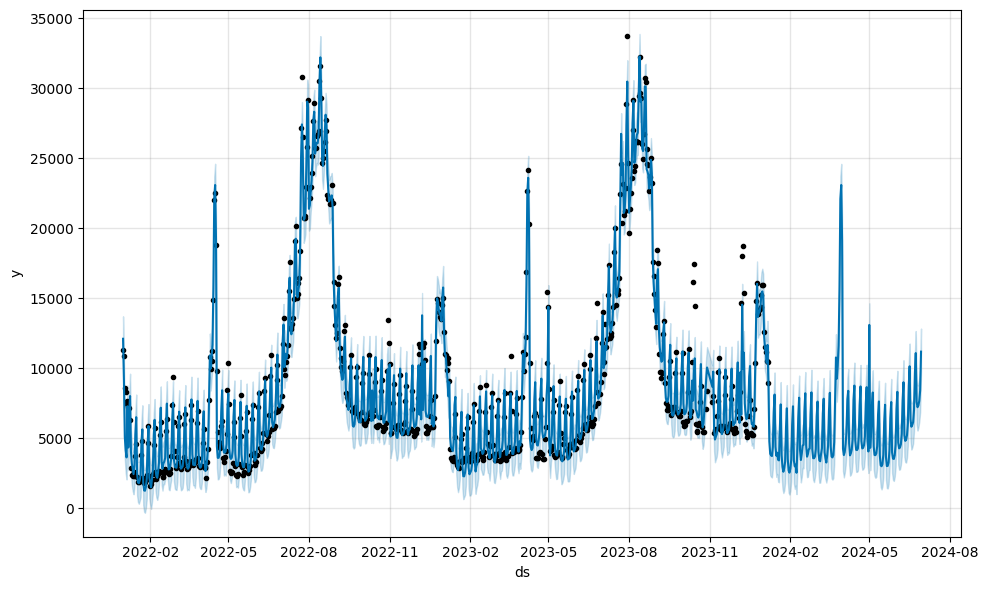

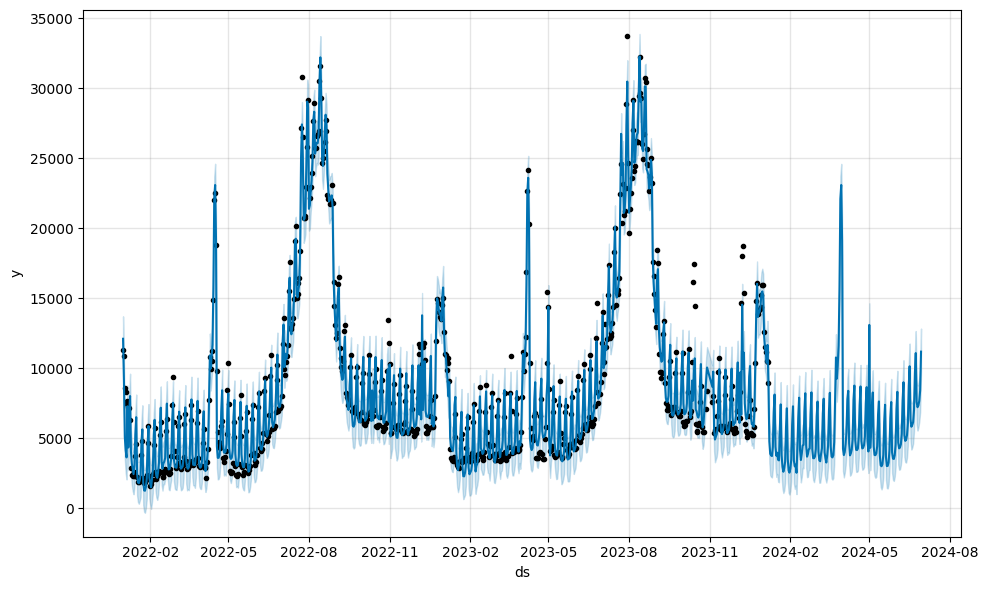

In [32]:
modelo_final.plot(forecast)


In [33]:
filename_csv = '/content/drive/My Drive/UNIRTFM/resultados/prophet_' + municipio + '.csv'
forecast.iloc[731:904].to_csv(filename_csv)

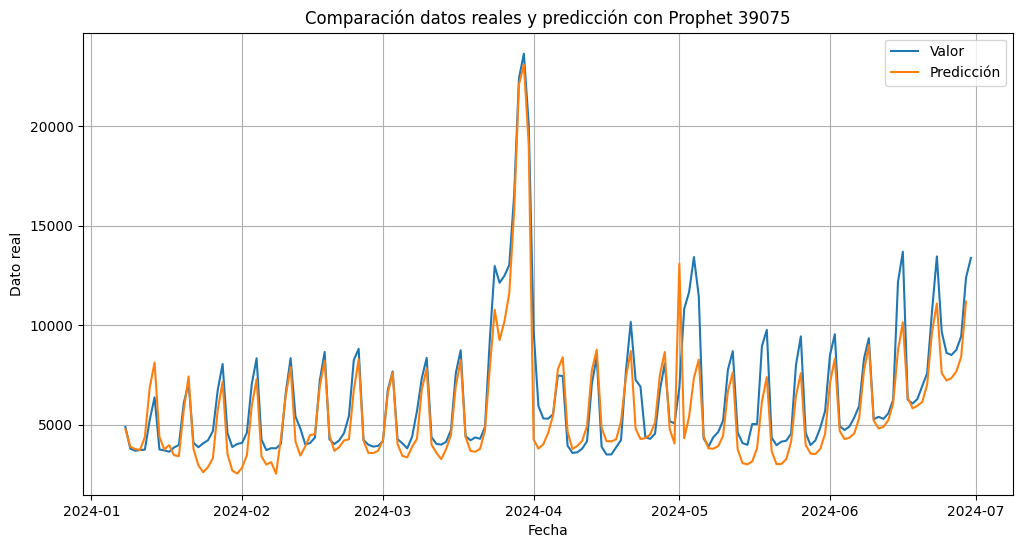

In [34]:

plt.figure(figsize=(12, 6))
plt.plot(df_final['ds'][730:], df_final['y'][730:], label='Valor')
plt.plot(forecast['ds'][730:], forecast['yhat'][730:], label='Predicción')

plt.xlabel('Fecha')
plt.ylabel('Dato real')
plt.title('Comparación datos reales y predicción con Prophet '+ municipio)
plt.legend()
plt.grid(True)
filename = '/content/drive/My Drive/UNIRTFM/figuras/prediccion_prophet_'+municipio+'.png'
plt.savefig(filename)
plt.show()

In [35]:
futuro.shape

(904, 6)